In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
# Set Dataset Path
DATASET_PATH = "/content/drive/MyDrive/Dog_s disease"

# Image Configuration
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42
image_paths = []
labels = []

#image_paths = []
labels = []

for class_name in os.listdir(DATASET_PATH):
    class_path = os.path.join(DATASET_PATH, class_name)

    if os.path.isdir(class_path):
        images = os.listdir(class_path)

        np.random.shuffle(images)

        images = images[:500]

        for img in images:
            image_paths.append(os.path.join(class_path, img))
            labels.append(class_name)

data_df = pd.DataFrame({
    "filename": image_paths,
    "class": labels
})

print("Total Images Used:", len(data_df))
print(data_df["class"].value_counts())


Total Images Used: 2822
class
Dermatitis           500
Healthy              500
ringworm             500
demodicosis          500
Fungal_infections    500
Hypersensitivity     322
Name: count, dtype: int64


In [ ]:
# Split the data into train (70%) and temp (30%)
train_df, temp_df = train_test_split(
    data_df,
    test_size=0.30,
    stratify=data_df["class"],
    random_state=SEED
)

# Split temp into validation (15%) and test (15%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["class"],
    random_state=SEED
)

print("Train:", len(train_df))
print("Validation:", len(val_df))
print("Test:", len(test_df))


Train: 1975
Validation: 423
Test: 424


In [ ]:
# ---------------- DATA GENERATORS ----------------
from sklearn.utils.class_weight import compute_class_weight # Added import

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8,1.2],
    horizontal_flip=True
)


val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filename",
    y_col="class",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)

val_gen = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col="filename",
    y_col="class",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col="filename",
    y_col="class",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# ---------------- CLASS INFO & CLASS WEIGHTS ----------------
class_names = list(train_gen.class_indices.keys())
num_classes = len(class_names)

# Compute class weights to handle imbalance
classes = np.arange(num_classes)
y_train_labels = train_df['class'].map(train_gen.class_indices).values
weights = compute_class_weight('balanced', classes=classes, y=y_train_labels)
class_weights = dict(zip(classes, weights))

print("Classes:", class_names)
print("Class weights:", class_weights)

Found 1975 validated image filenames belonging to 6 classes.
Found 423 validated image filenames belonging to 6 classes.
Found 424 validated image filenames belonging to 6 classes.
Classes: ['Dermatitis', 'Fungal_infections', 'Healthy', 'Hypersensitivity', 'demodicosis', 'ringworm']
Class weights: {np.int64(0): np.float64(0.9404761904761905), np.int64(1): np.float64(0.9404761904761905), np.int64(2): np.float64(0.9404761904761905), np.int64(3): np.float64(1.462962962962963), np.int64(4): np.float64(0.9404761904761905), np.int64(5): np.float64(0.9404761904761905)}


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

def build_crnn(num_classes, IMG_SIZE):

    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # ---------- CNN FEATURE EXTRACTOR ----------
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D(2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.BatchNormalization()(x)

    # ---------- CNN → RNN ----------
    # (batch, time_steps, features)
    x = layers.Reshape(
        (x.shape[1], x.shape[2] * x.shape[3])
    )(x)

    # ---------- RNN BLOCK ----------
    x = layers.Bidirectional(
        layers.GRU(128, return_sequences=True)
    )(x)

    x = layers.Bidirectional(
        layers.GRU(64)
    )(x)

    # ---------- CLASSIFIER ----------
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return models.Model(inputs, outputs)


model = build_crnn(num_classes, IMG_SIZE)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 3584)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 28, 256)        │     2,852,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       123,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,087,430 (11.78 MB)

 Trainable params: 3,086,982 (11.78 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        "/content/drive/MyDrive/dog_skin_disease_CRNN.",
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]


In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=40,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
Epoch 1/40
62/62 ━━━━━━━━━━━━━━━━━━━━━━━━━ 63s 610ms/step - accuracy: 0.2309 - loss: 2.1365 - val_accuracy: 0.1229 - val_loss: 3.6238 - learning_rate: 0.0010
INFO:absl:Saving model to best_model.keras
Epoch 2/40
62/62 ━━━━━━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.2475 - loss: 2.0852 WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
62/62 ━━━━━━━━━━━━━━━━━━━━━━━━━ 61s 662ms/ste

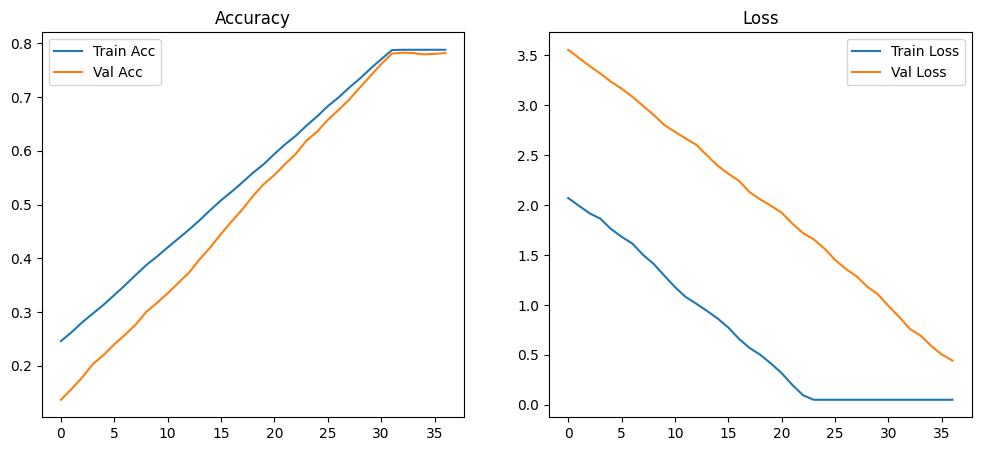

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()


In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_gen)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

14/14 ━━━━━━━━━━━━━━━━━━━━━━━━━ 434s 20s/step - accuracy: 0.7875 - loss: 1.0333
Test Loss: 1.0408583879470825
Test Accuracy: 0.7612


In [ ]:
test_gen.reset()
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

report = classification_report(
    y_true,
    y_pred,
    target_names=class_names
)

print("Classification Report:\n")
print(report)

Classification Report:

                   precision    recall  f1-score   support

       Dermatitis     0.7564    0.7867    0.7712        75
          Healthy     0.8194    0.7867    0.8027        75
         ringworm     0.7564    0.7867    0.7712        75
      demodicosis     0.7763    0.7867    0.7815        75
Fungal_infections     0.9219    0.7867    0.8489        75
 Hypersensitivity     0.6786    0.7755    0.7238        49

         accuracy                         0.7854       424
        macro avg     0.7848    0.7848    0.7832       424
     weighted avg     0.7914    0.7854    0.7869       424



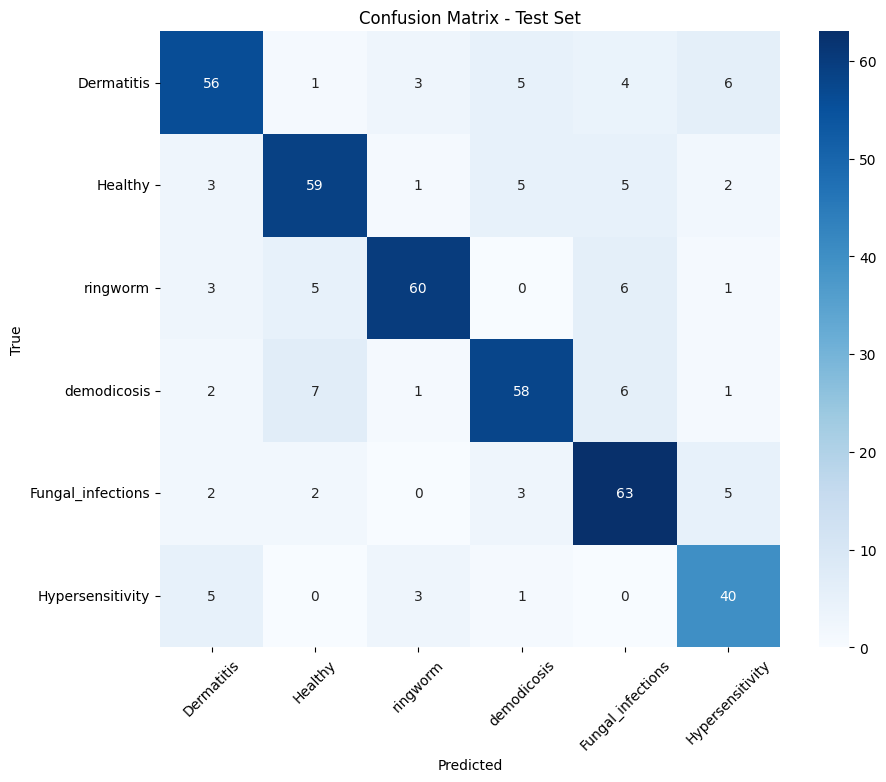

In [ ]:
test_gen.reset()
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

cm = confusion_matrix(y_true, y_pred)
z
plt.figure(figsize=(10,8))
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.xticks(rotation=45)
plt.show()


In [ ]:
model.save("/content/drive/MyDrive/dog_disease_CRNN.h5")
print("Model Saved Successfully!")

Model Saved Successfully!
